# Exploratory Analysis

In this notebook I explore the audio files by playing, plotting, and performing signal processing techniques on them.


In [1]:
# Imports

import pyaudio
import wave
import numpy as np
import seaborn as sns
import math

from scipy.signal import butter, lfilter
from scipy.fftpack import fft, ifft, rfft, irfft, fftfreq,  rfftfreq
%matplotlib inline

In [2]:
# Instruments & Notes
# all sampled at 44100 Hz

path = "/Users/kevin_katzmann/ds/Metis/projects/Kojak/music/"

piano_notes = ["piano/notes/C4.wav",
               "piano/notes/D4.wav",
               "piano/notes/E4.wav",
               "piano/notes/G4.wav",
              ]

piano_chords = ["piano/chords/1_5.wav",
                "piano/chords/1_2.wav",
                "piano/chords/1_3_5.wav",
               ]

piano_playing = ["piano/playing/playing_001.wav",
                ]

test_data_set = ["dataset/piano/C4_E4.wav",
                 "dataset/flute/C4_E4.wav",
                ]

lowcut = 20
highcut = 16000

In [3]:
# %load sound_check.py
# Helper/initial check functions
# run cell twice when loading in a jupyter notebook, and use: %load kojak_helpers.py

import pyaudio
import wave
import numpy as np
from scipy.signal import butter, lfilter


# Play a wav file
def play_wav(file,path=None):
    file = path+file if path else file
    print("Playing: ", file)
    chunk = 1024//2
    f = wave.open(file,"rb")
    p = pyaudio.PyAudio()
    stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                    channels = f.getnchannels(),  
                    rate = f.getframerate(),  
                    output = True)
    data = f.readframes(chunk)
    while data:  
        stream.write(data)  
        data = f.readframes(chunk)
    stream.stop_stream()  
    stream.close()    
    p.terminate()


# Convert stereo tracks to mono
def ster_to_mon(frames):
    frames = frames[:-1] if len(frames)%2>0 else frames
    newaudiodata = []
    for i in range(0,len(frames),2):
        d = (frames[i] + frames[i+1])/2
        newaudiodata.append(d)
    return np.array(newaudiodata, dtype='int16')


# Opens wav file
def open_wav(file,path=None):
    file = path+file if path else file
    print("Opening: ",file)
    f = wave.open(file, "rb")
    frames = np.fromstring(f.readframes(-1), 'Int16')
    frames = ster_to_mon(frames) if f.getnchannels()==2 else frames
    rate = f.getframerate()
    f.close()
    return frames, rate

# Simple plot of wav file
def quickplot_wav(file,path=None):
    frames, rate = open_wav(file,path=path)
    times = [(x[0]/rate) for x in list(enumerate(frames))]
    sns.plt.figure()
    sns.plt.title('Signal Wave')
    sns.plt.xlabel("Time")
    sns.plt.ylabel("Amplitude")
    sns.plt.plot(times,frames)
    sns.plt.show()


Playing:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav
Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav


/Users/kevin_katzmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


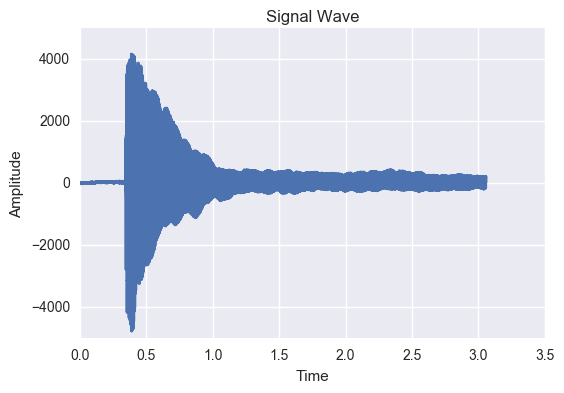

In [4]:
play_wav(piano_notes[0],path=path)
quickplot_wav(piano_notes[0],path=path)

In [5]:
# Butterworth passband filter (can be visualized with 'plot_wav' function)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = lfilter(b, a, data)
    return filtered


In [6]:
# Plots wav file, with butterworth filter option

def plot_wav(file,start=None,stop=None,butter=False,lowcut=lowcut,highcut=highcut,path=None):
    frames, rate = open_wav(file,path=path)
    
    if butter==True:
        frames = butter_bandpass_filter(frames, lowcut, highcut, rate, order=2) # order=2 seems to work the best in this case
    
    start = 0 if start==None else start
    stop = len(frames) if stop==None else stop
    
    frames = frames[int(start*rate):int(stop*rate)]
    times = [(x[0]/rate) for x in list(enumerate(frames))]
    
    sns.plt.figure()
    sns.plt.title('Signal Wave')
    sns.plt.xlabel("Time")
    sns.plt.ylabel("Amplitude")
    sns.plt.plot(times,frames)
    sns.plt.show()


Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav


/Users/kevin_katzmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


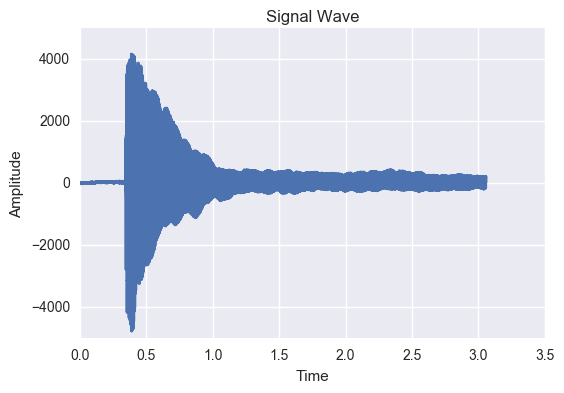

Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav


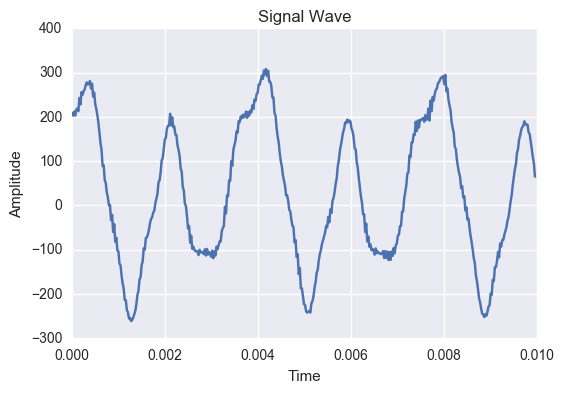

Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav


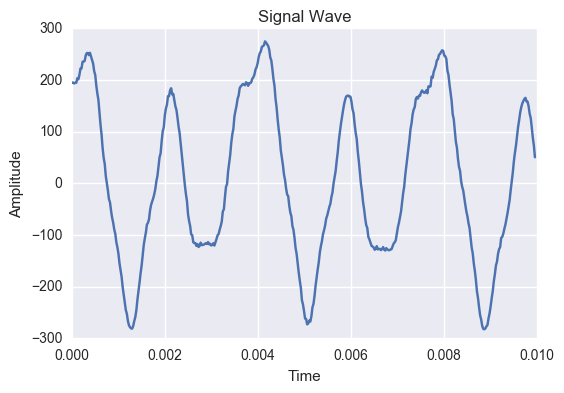

In [7]:
plot_wav(piano_notes[0],path=path)
plot_wav(piano_notes[0],2,2.01,path=path)
plot_wav(piano_notes[0],2,2.01,butter=True,path=path)

In [8]:
# Plot fft of chunk directly from file

def plot_fft(file,start=None,stop=None,xlimit=4000,butter=False,lowcut=lowcut,highcut=highcut,plot=True,path=None):
    frames, rate = open_wav(file,path)
    
    if butter==True:
        frames = butter_bandpass_filter(frames, lowcut, highcut, rate, order=2)
    
    start = 0 if start==None else start
    stop = len(frames) if stop==None else stop
    
    frames = frames[int(start*rate):int(stop*rate)]  

    n = len(frames)
    unique = len(frames)//2
    
    amp = np.abs(rfft(frames)[:unique])
    freq = np.abs(fftfreq(n,d=((stop-start)/(unique)))[:unique])
    
    if plot == False:
        return amp, freq, frames, rate, n, unique
    
    sns.plt.figure()
    sns.plt.plot(freq,amp)
    sns.plt.xlim(0,xlimit)
    sns.plt.title("FFT")
    sns.plt.xlabel("Frequency (Hz)")
    sns.plt.ylabel("Total Amplitude")
    sns.plt.show()


Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav


/Users/kevin_katzmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


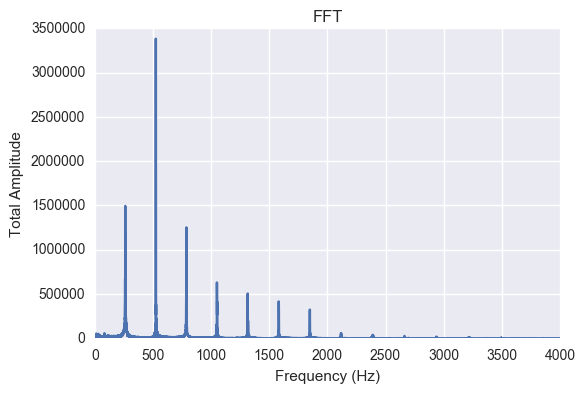

Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/chords/1_5.wav


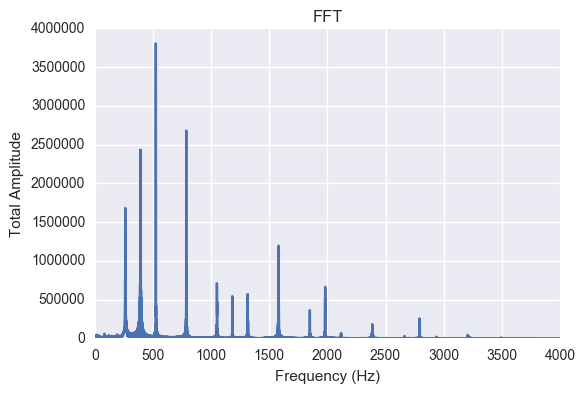

In [9]:
plot_fft(piano_notes[0],start=1,stop=2,butter=True,path=path)
plot_fft(piano_chords[0],start=1,stop=2,butter=True,path=path)

In [10]:
def plot_power(file,start,stop,xlimit=4000,butter=False,path=None):
    amp, freq, frames, rate, n, unique = plot_fft(file,start=start,stop=stop,butter=butter,plot=False,path=path)
    
    # to get dB from amplitude:
        # amp**2 -> pow; 10*log10(pow) -> dB
        
    power = ((abs(amp[:unique]))/float(n))**2
    
    # Since we dropped half the FFT, we multiply mx by 2 to keep the same energy.
    # The DC component and Nyquist component, if it exists, are unique and should not be multiplied by 2.
    
    if n % 2 > 0:
        power[1:] = power[1:] * 2
    else:
        power[1:-1] = power[1:-1] * 2 
    
    dB = [math.log10(x) for x in power]
    
    sns.plt.figure()
    sns.plt.plot(abs(freq[:unique]),dB)
    sns.plt.xlim(0,xlimit)
    sns.plt.title("Power")
    sns.plt.xlabel("Frequency (Hz)")
    sns.plt.ylabel("Power (dB)")
    sns.plt.show()
    
    #paired = zip(np.abs(freq),np.abs(amp))
    #print("Max freq: ",max(paired, key=lambda x: x[1]))


Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/16mono/C4.wav


/Users/kevin_katzmann/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.


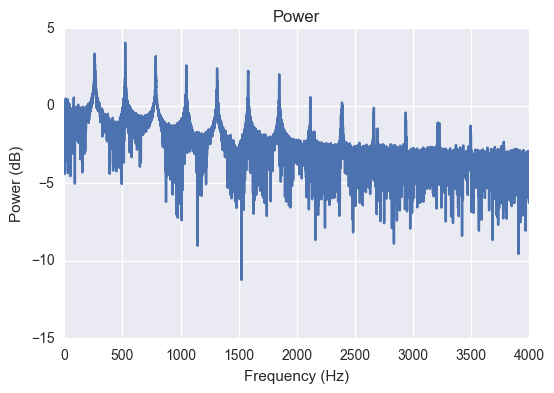

Opening:  /Users/kevin_katzmann/ds/Metis/projects/Kojak/music/piano/chords/1_5.wav


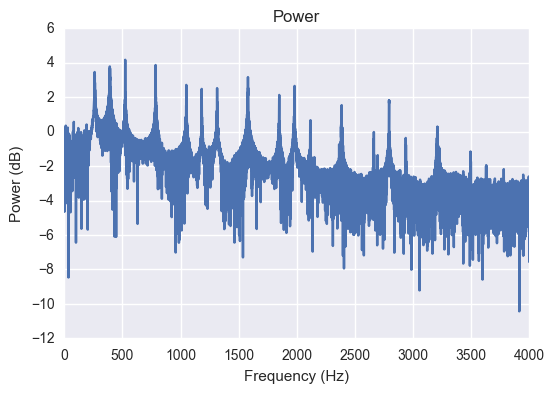

In [11]:
plot_power(piano_notes[0],start=1,stop=2,butter=True,path=path)
plot_power(piano_chords[0],start=1,stop=2,butter=True,path=path)